In [6]:
# pip install bert-score

In [7]:
# pip install evaluate

In [8]:
# pip install rouge_score

In [9]:
# pip install emoji

In [10]:
# pip install sentence-transformers

In [11]:
import nltk
from datasets import load_dataset
import evaluate
import numpy as np
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from statistics import mean 
from rouge_score import rouge_scorer
from bert_score import score
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from textblob import TextBlob
import emoji
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification,AutoModelForCausalLM, AutoTokenizer, pipeline 
import numpy as np
from scipy.special import expit
from wordcloud import WordCloud
from datasets import load_dataset
import torch
from sentence_transformers import SentenceTransformer
import copy

2024-07-30 13:20:44.531311: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 13:20:44.531418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 13:20:44.695365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [19]:
qa_dataset = load_dataset("toughdata/quora-question-answer-dataset")

Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [20]:
qa_dataset['train']

Dataset({
    features: ['question', 'answer'],
    num_rows: 56402
})

## EDA and pre-preprocessing

In [14]:
df=pd.DataFrame()
df['question']=qa_dataset['train']['question']
df['answer']=qa_dataset['train']['answer']

In [15]:
df.isna().sum(),len(df),df.duplicated().sum(),df['question'].nunique()

(question    0
 answer      0
 dtype: int64,
 56402,
 1220,
 3234)

In [16]:
df=df[~df.duplicated()]
df.reset_index(drop=True,inplace=True)

In [17]:
df=df.drop_duplicates(subset='question')
df.reset_index(drop=True,inplace=True)

In [18]:
def html_tag_cleaner(text):
    return BeautifulSoup(text, "html.parser").get_text()

def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+', '', text)

def replace_newlines(text):
    return text.replace('\n', ' ')

def remove_spaces(text):
    return text.strip()

def correct_spelling_text(text):
    return str(TextBlob(text).correct())

def remove_emojis(text):
    return emoji.replace_emoji(text, "")


In [19]:
df['question'] = df['question'].apply(html_tag_cleaner)
df['answer'] = df['answer'].apply(html_tag_cleaner)

df['question'] = df['question'].apply(remove_urls)
df['answer'] = df['answer'].apply(remove_urls)

df['question'] = df['question'].apply(replace_newlines)
df['answer'] = df['answer'].apply(replace_newlines)

df['question'] = df['question'].apply(remove_emojis)
df['answer'] = df['answer'].apply(remove_emojis)

df['question'] = df['question'].apply(remove_spaces)
df['answer'] = df['answer'].apply(remove_spaces)


/tmp/ipykernel_34/3326662870.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()
/tmp/ipykernel_34/3326662870.py:2: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


In [20]:
# df['question'] = df['question'].apply(correct_spelling_text)
# df['answer'] = df['answer'].apply(correct_spelling_text)

In [21]:
length_questions=[len(x.strip().split()) for x in df['question'].unique()]
length_answers=[len(x.strip().split()) for x in df['answer'].unique()]

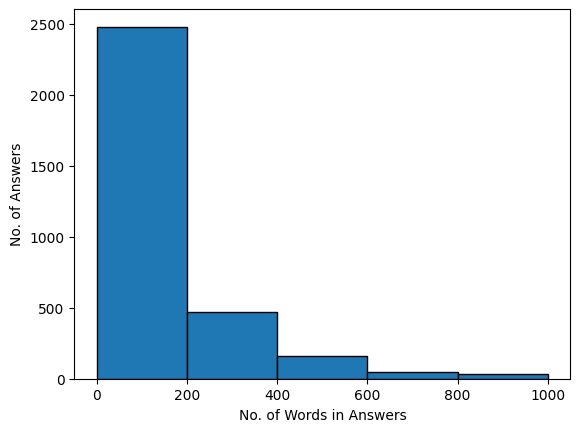

In [22]:
# histogram plot
plt.hist(length_answers, bins=5, edgecolor='black',range=(0,1000))
plt.xlabel('No. of Words in Answers')
plt.ylabel('No. of Answers')
plt.title('')
plt.show()

In [71]:
# # Scatter plot
# plt.scatter(range(len(length_answers)),length_answers)
# plt.xlabel('X Axis')
# plt.ylabel('Y Axis')
# plt.title('Length_questions')
# plt.show()

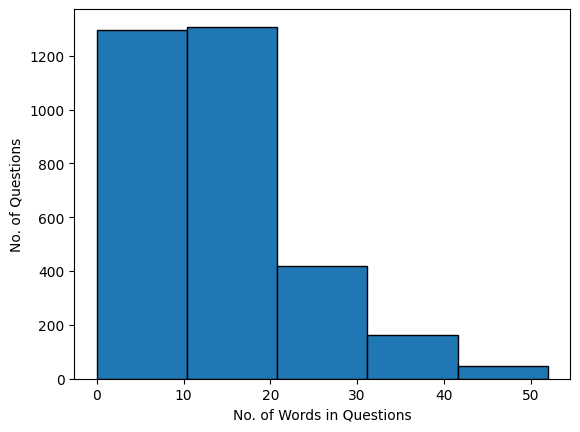

In [58]:
# histogram plot
plt.hist(length_questions, bins=5, edgecolor='black')
plt.xlabel('No. of Words in Questions')
plt.ylabel('No. of Questions')
plt.title('')
plt.show()

In [72]:
MODEL = f"cardiffnlp/tweet-topic-latest-multi"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
class_mapping = model.config.id2label

def topic_classification(text):
    tokens = tokenizer(text, return_tensors='pt')
    output = model(**tokens)
    scores = output[0][0].detach().numpy()
    scores = expit(scores)
    predictions = (scores >= 0.5) * 1
    for i in range(len(predictions)):
        if predictions[i]:
            return class_mapping[i]



In [74]:
temp=copy.deepcopy(df)
temp=temp.drop_duplicates(subset='question')
temp.reset_index(drop=True,inplace=True)
temp['topic'] = temp['question'].apply(topic_classification)


In [75]:
temp['topic'].value_counts()

topic
news_&_social_concern       544
diaries_&_daily_life        497
science_&_technology        474
business_&_entrepreneurs    389
celebrity_&_pop_culture     188
learning_&_educational      152
fitness_&_health            151
film_tv_&_video             141
food_&_dining                99
sports                       93
arts_&_culture               83
travel_&_adventure           65
gaming                       49
music                        39
fashion_&_style              29
other_hobbies                15
family                        7
relationships                 2
Name: count, dtype: int64

In [77]:
len(temp)

3232

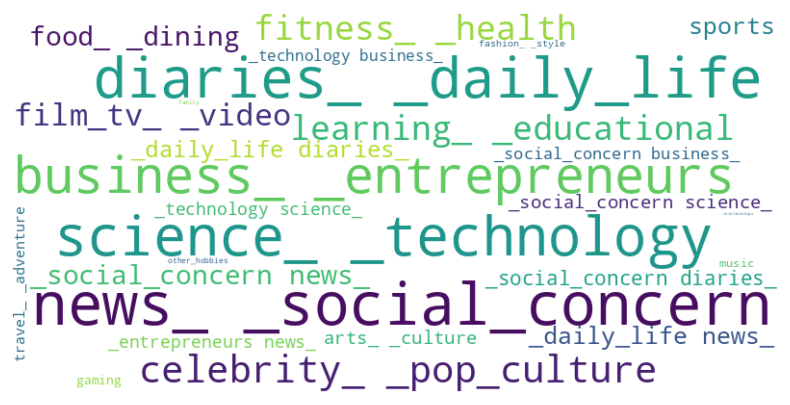

In [76]:
text = ' '.join(temp['topic'].dropna().astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
orig_df=copy.deepcopy(df)

In [23]:
df=df[:50]
df.reset_index(drop=True,inplace=True)

# Model testing

## microsoft/Phi-3-mini-4k-instruct

In [12]:


torch.random.manual_seed(0) 
model = AutoModelForCausalLM.from_pretrained( 
    "microsoft/Phi-3-mini-4k-instruct",  
    device_map="cuda",  
    torch_dtype="auto",  
    trust_remote_code=True,  
) 

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct") 



config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
rouge1={}
rouge2={}
rougel={}
bert_f1={}
bert_p={}
bert_r={}
generated_ans={}
ques_asked={}
actual_ans={}
for i in range(len(df)):
    if i%50==0:
        print(i)
    
    

    messages = [ 
        {"role": "system", "content": "You are a helpful assistant"}, 
        {"role": "user", "content": df['question'][i]} 
    ] 

    pipe = pipeline( 
        "text-generation", 
        model=model, 
        tokenizer=tokenizer, 
    ) 

    generation_args = { 
        "max_new_tokens": 300 
    } 

    output = pipe(messages, **generation_args) 
    answer=output[0]['generated_text']
    generated_ans[i]=answer[2]['content']
    ques_asked[i]=answer[1]['content']
    actual_ans[i]=df['answer'][i]
    
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(df['answer'][i], answer[2]['content'])
    rouge1[i]=scores['rouge1']
    rouge2[i]=scores['rouge2']
    rougel[i]=scores['rougeL']
    
    p,r,f1=score([answer[2]['content']],[df['answer'][i]],lang='en',verbose=True )
    bert_f1[i]=f1.mean()
    bert_p[i]=p.mean()
    bert_r[i]=r.mean()




0


The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.39 seconds, 2.59 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.68 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.35 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.07 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.83 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.08 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.23 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.79 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.19 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.62 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.97 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 10.71 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.33 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.76 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.96 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.28 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.87 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.41 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.44 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 4.93 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.82 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 4.99 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.63 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.96 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.41 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 10.81 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.49 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.55 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 11.95 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.05 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.97 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.00 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.95 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.58 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.69 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.90 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 10.54 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.53 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.74 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.16 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.46 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 11.47 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.13 seconds, 7.43 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.30 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.19 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.68 sentences/sec


In [26]:
rouge1_precision=[]
rouge2_precision=[]
rougel_precision=[]

rouge1_recall=[]
rouge2_recall=[]
rougel_recall=[]

rouge1_fmeasure=[]
rouge2_fmeasure=[]
rougel_fmeasure=[]

bert_f1_list=[]
bert_p_list=[]
bert_r_list=[]

generates_ans_list=[]

for each in rouge1:
    rouge1_precision.append(rouge1[each][0])
    rouge1_recall.append(rouge1[each][1])
    rouge1_fmeasure.append(rouge1[each][2])

for each in rougel:
    rougel_precision.append(rougel[each][0])
    rougel_recall.append(rougel[each][1])
    rougel_fmeasure.append(rougel[each][2])
    
for each in rouge2:
    rouge2_precision.append(rouge2[each][0])
    rouge2_recall.append(rouge2[each][1])
    rouge2_fmeasure.append(rouge2[each][2])
        
    
for each in bert_f1:
    bert_p_list.append(bert_p[each].item())
for each in bert_r:
    bert_r_list.append(bert_r[each].item())
for each in bert_f1:
    bert_f1_list.append(bert_f1[each].item())

for each in generated_ans:
    generates_ans_list.append(generated_ans[each])

In [27]:
mean(rouge2_precision),mean(rouge2_recall),mean(rouge2_fmeasure)

(0.032699882303532164, 0.049121643634226574, 0.026545099239783345)

In [28]:
mean(rouge1_precision),mean(rouge1_recall),mean(rouge1_fmeasure)

(0.20316171988943893, 0.32577703259532687, 0.16547996931850006)

In [29]:
mean(rougel_precision),mean(rougel_recall),mean(rougel_fmeasure)

(0.12482174962899843, 0.2166991457425184, 0.09824832547682162)

In [30]:
max(rouge2_precision),max(rouge2_recall),max(rouge2_fmeasure)

(0.20270270270270271, 0.4, 0.12189616252821671)

In [31]:
min(rouge2_precision),min(rouge2_recall),min(rouge2_fmeasure)

(0.0, 0.0, 0.0)

In [33]:
max(rouge1_precision),max(rouge1_recall),max(rouge1_fmeasure)

(0.6358024691358025, 1.0, 0.47191011235955055)

In [34]:
max(rougel_precision),max(rougel_recall),max(rougel_fmeasure)

(0.5, 0.8333333333333334, 0.25617977528089886)

In [36]:
mean(bert_f1_list),mean(bert_p_list),mean(bert_r_list)


(0.8197922539710999, 0.8163738644123077, 0.8241610753536225)

In [37]:
max(bert_f1_list),max(bert_p_list),max(bert_r_list)


(0.8733823895454407, 0.8762829303741455, 0.8960256576538086)

In [38]:
min(bert_f1_list),min(bert_p_list),min(bert_r_list)

(0.7602677941322327, 0.7557680606842041, 0.7648214101791382)

In [153]:
length_ans=[len(x) for x in df['answer']]
length_gen_ans=[len(x) for x in df['generated_ans']]

In [154]:
len_dict={'less_50': 0,'50_100': 0,'100_200': 0,'200_300': 0,'300_500': 0,'>=500':0}
for each in length_gen_ans:
    if each < 50:
        len_dict['less_50']=len_dict['less_50']+1
    if (each >= 50) & (each < 100):
        len_dict['50_100']=len_dict['50_100']+1
        
    if (each >= 100) & (each < 200):
        len_dict['100_200']=len_dict['100_200']+1
        
    if (each >= 200) & (each < 300):
        len_dict['200_300']=len_dict['200_300']+1
        
    if (each >= 300) & (each < 500):
        len_dict['300_500']=len_dict['300_500']+1
        
    if (each>=500):
        len_dict['>=500']=len_dict['>=500']+1
        

In [155]:
len_dict

{'less_50': 0,
 '50_100': 0,
 '100_200': 1,
 '200_300': 5,
 '300_500': 5,
 '>=500': 39}

In [156]:
len_dict

{'less_50': 0,
 '50_100': 0,
 '100_200': 1,
 '200_300': 5,
 '300_500': 5,
 '>=500': 39}

In [39]:
df['rouge1_precesion']=rouge1_precision
df['rouge2_precesion']=rouge2_precision
df['rougel_precision']=rougel_precision

df['rouge1_recall']=rouge1_recall
df['rouge2_recall']=rouge2_recall
df['rougel_recall']=rougel_recall

df['rouge1_fmeasure']=rouge1_fmeasure
df['rouge2_fmeasure']=rouge2_fmeasure
df['rougel_fmeasure']=rougel_fmeasure



df['bert_f1']=bert_f1_list
df['bert_p']=bert_p_list
df['bert_r']=bert_r_list


df['generated_ans']=generates_ans_list

In [40]:
df['generated_ans'] = df['generated_ans'].apply(html_tag_cleaner)

df['generated_ans'] = df['generated_ans'].apply(remove_urls)

df['generated_ans'] = df['generated_ans'].apply(replace_newlines)

df['generated_ans'] = df['generated_ans'].apply(remove_spaces)


In [29]:
sim_model=SentenceTransformer('distilbert-base-nli-mean-tokens')

def sts_func(llm_ans, actual_answer):
    sent1=actual_answer
    sent2=llm_ans

    enc1=sim_model.encode(sent1)
    enc2=sim_model.encode(sent2)

    sent1=actual_answer
    sent2=llm_ans

    enc1=sim_model.encode(sent1)
    enc2=sim_model.encode(sent2)

    return np.dot(enc1,enc2)/(np.linalg.norm(enc1)*(np.linalg.norm(enc2)))


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [42]:
df['sts_score']=df.apply(lambda row: sts_func(row['generated_ans'],row['answer']),axis=1)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
df['sts_score'].describe()

count    50.000000
mean      0.563698
std       0.251015
min      -0.028323
25%       0.468699
50%       0.598312
75%       0.773840
max       0.919481
Name: sts_score, dtype: float64

In [177]:
len_dict={'less_0.5': 0,'0.5_0.7': 0,'>=0.7':0}
for each in df['sts_score']:
    
    if each < 0.5:
        len_dict['less_0.5']=len_dict['less_0.5']+1
    
    if (each >= 0.5) & (each < 0.7):
        len_dict['0.5_0.7']=len_dict['0.5_0.7']+1
    
    if (each>=0.7):
        len_dict['>=0.7']=len_dict['>=0.7']+1
        

In [205]:
temp=df[(df['sts_score']>0.6) & (df['sts_score']<0.7)]
temp.reset_index(drop=True,inplace=True)
print(len(temp))


10


In [206]:
temp['question'][1],temp['answer'][1]

('Now do people who eat only once or twice a day manage to not feel hungry between meals?',
 'The body adjust after few days and even if they feel bit hungry it is not an issue. Humans have evolved in environment where you didn eat 3–5 times per day. You went for days without food.')

In [207]:
temp['generated_ans'][1]

'People who eat only once or twice a day, often referred to as intermittent fasting, can manage to not feel hungry between meals for various reasons. Here are some factors that contribute to this:  1. Hormonal changes: When you fast, your body releases a hormone called ghrelin, which signals hunger. However, as you continue to fast, your body starts to adapt by reducing the production of ghrelin, which can help you feel less hungry.  2. Increased insulin sensitivity: Intermittent fasting can improve insulin sensitivity, which helps your body use glucose more efficiently. This can lead to a more stable blood sugar level, reducing hunger and cravings.  3. Reduced inflammation: Intermittent fasting has been shown to reduce inflammation in the body, which can help regulate appetite and reduce feelings of hunger.  4. Changes in gut microbiota: Intermittent fasting can alter the composition of bacteria in the gut, which can influence appetite and satiety.  5. Psychological factors: Some peop

In [56]:
df['question'][17]

'Having at 62, I have no pension. I haven’t payed enough in for old age pension and I am alone. What will I do? I work a few hours, have no savings, and live week to week. I live in Britain.'

In [62]:
df['question'][14],df['answer'][14],

('How difficult was it for you to find your life purpose?',
 'I think if you can find something that you can do, enjoy, but most importantly SERVE other people, that can be your life’s purpose. It can feed you not only literally with a rewarding career, but also emotionally and spiritually in serving, protecting, and helping others.  I did it by helping out my fellow Asian brothers fight stereotypes and racism after I was hired by a Chinese Canadian mother who wanted me to help out her son who had been harassed by neo-Nazi’s.  For Captain Daniel Hyun here, he served in the military which later inspired to find his life purpose after he retired by also helping out his fellow brothers:')

In [63]:
df['question'][14],df['generated_ans'][14],

('How difficult was it for you to find your life purpose?',
 "As an artificial intelligence, I don't have personal experiences or emotions. I don't have a life purpose in the way humans do. My purpose is to assist users like you by providing information, answering questions, and helping with various tasks.")

In [64]:
df['sts_score'][14]

0.2838514

In [61]:
df['question'][14]

'How difficult was it for you to find your life purpose?'

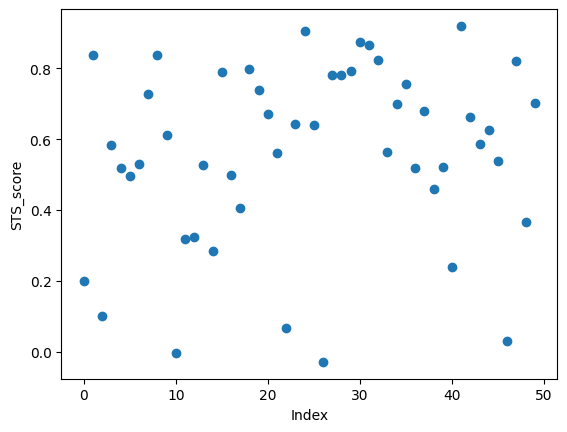

In [48]:
# Scatter plot
plt.scatter(df.index,df['sts_score'])
plt.xlabel('Index')
plt.ylabel('STS_score')
# plt.title()
plt.show()

## openai-community/gpt2-medium and openai-community/gpt2-large

In [96]:
df2=copy.deepcopy(orig_df)
df2=df2[:50]
df2.reset_index(drop=True,inplace=True)

In [97]:
len(df2)

50

In [103]:
from transformers import pipeline, set_seed

tokenizer = AutoTokenizer.from_pretrained('gpt2-medium')
generator = pipeline('text-generation', model='gpt2-medium')
set_seed(42)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [104]:
generator(df['question'][5])


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'That are useful free and open-source tools for drops and sysadmin folks?'},
 {'generated_text': 'That are useful free and open-source tools for drops and sysadmin folks?\n\nI would encourage anyone seeking out the OpenStack community to read the release notes and to go to these two very good introductory talks – by Tom Leung and Patrick'},
 {'generated_text': 'That are useful free and open-source tools for drops and sysadmin folks?\n\nWhat do they do?\n\nHow can I use them?\n\nI get no support from these companies?\n\nDo they pay me to take care'},
 {'generated_text': "That are useful free and open-source tools for drops and sysadmin folks? Who knows; but what's better than open source, anyway? We are not sure, but we know these might be good things for someone like you, somebody who might"},
 {'generated_text': 'That are useful free and open-source tools for drops and sysadmin folks? I think not. The key reason is that the tools are proprietary and therefore, no c

In [108]:
from transformers import pipeline, set_seed

tokenizer = AutoTokenizer.from_pretrained('gpt2-large')
generator = pipeline('text-generation', model='gpt2-large')
set_seed(42)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [110]:
generator(df['question'][5])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "That are useful free and open-source tools for drops and sysadmin folks?\n\nThis is something that we use a lot in our internal projects with our main product, i.e. DropTest, but it's a tool that should be"}]

In [ ]:
question: That are useful free and open-source tools for drops and sysadmin folks?
answer:   This is something that we use a lot in our internal projects with our main product,
          i.e. DropTest, but it's a tool that should be

## TinyLlama/TinyLlama-1.1B-Chat-v1.0

In [30]:
df3=copy.deepcopy(orig_df)

df3=df3[:50]
df3.reset_index(drop=True,inplace=True)

In [31]:
rouge1={}
rouge2={}
rougel={}
bert_f1={}
bert_p={}
bert_r={}
generated_ans={}
ques_asked={}
actual_ans={}
for i in range(len(df3)):
    if i%50==0:
        print(i)
    messages = [{"role": "system","content": "You are a helpful assistant."},
                    {"role": "user", "content": df3['question'][i]}]
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    output = pipe(prompt, max_new_tokens=300, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)

    answer=output[0]["generated_text"].split('<|assistant|>\n')[-1]
    generated_ans[i]=answer
    ques_asked[i]=df['question'][i]
    actual_ans[i]=df['answer'][i]
    
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(df['answer'][i], answer)
    rouge1[i]=scores['rouge1']
    rouge2[i]=scores['rouge2']
    rougel[i]=scores['rougeL']
    
    p,r,f1=score([answer],[df['answer'][i]],lang='en',verbose=True )
    bert_f1[i]=f1.mean()
    bert_p[i]=p.mean()
    bert_r[i]=r.mean()




0


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.70 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.15 seconds, 6.88 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.05 seconds, 18.63 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.50 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.89 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.72 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.08 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.80 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.22 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.94 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.42 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.43 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.74 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 11.36 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.40 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.24 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.24 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.70 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.36 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.04 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.13 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.25 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.31 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.19 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.28 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 10.93 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.42 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.01 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 15.56 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.38 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.88 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.21 seconds, 4.78 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.01 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 11.06 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.75 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.56 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.47 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.63 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.14 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.67 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 15.38 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.95 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.80 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.25 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.78 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 11.64 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.24 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.51 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.81 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.30 sentences/sec


In [32]:
rouge1_precision=[]
rouge2_precision=[]
rougel_precision=[]

rouge1_recall=[]
rouge2_recall=[]
rougel_recall=[]

rouge1_fmeasure=[]
rouge2_fmeasure=[]
rougel_fmeasure=[]

bert_f1_list=[]
bert_p_list=[]
bert_r_list=[]

generates_ans_list=[]

for each in rouge1:
    rouge1_precision.append(rouge1[each][0])
    rouge1_recall.append(rouge1[each][1])
    rouge1_fmeasure.append(rouge1[each][2])

for each in rougel:
    rougel_precision.append(rougel[each][0])
    rougel_recall.append(rougel[each][1])
    rougel_fmeasure.append(rougel[each][2])
    
for each in rouge2:
    rouge2_precision.append(rouge2[each][0])
    rouge2_recall.append(rouge2[each][1])
    rouge2_fmeasure.append(rouge2[each][2])
        
    
for each in bert_f1:
    bert_p_list.append(bert_p[each].item())
for each in bert_r:
    bert_r_list.append(bert_r[each].item())
for each in bert_f1:
    bert_f1_list.append(bert_f1[each].item())

for each in generated_ans:
    generates_ans_list.append(generated_ans[each])

In [33]:
df3['rouge1_precesion']=rouge1_precision
df3['rouge2_precesion']=rouge2_precision
df3['rougel_precision']=rougel_precision

df3['rouge1_recall']=rouge1_recall
df3['rouge2_recall']=rouge2_recall
df3['rougel_recall']=rougel_recall

df3['rouge1_fmeasure']=rouge1_fmeasure
df3['rouge2_fmeasure']=rouge2_fmeasure
df3['rougel_fmeasure']=rougel_fmeasure

df3['bert_f1']=bert_f1_list
df3['bert_p']=bert_p_list
df3['bert_r']=bert_r_list


df3['generated_ans']=generates_ans_list

df3['generated_ans'] = df3['generated_ans'].apply(html_tag_cleaner)

df3['generated_ans'] = df3['generated_ans'].apply(remove_urls)

df3['generated_ans'] = df3['generated_ans'].apply(replace_newlines)

df3['generated_ans'] = df3['generated_ans'].apply(remove_spaces)


In [35]:
df3.head()

,question,answer,rouge1_precesion,rouge2_precesion,rougel_precision,rouge1_recall,rouge2_recall,rougel_recall,rouge1_fmeasure,rouge2_fmeasure,rougel_fmeasure,bert_f1,bert_p,bert_r,generated_ans
0,Why whenever I get in the shower my girlfriend...,Isn’t it awful? You would swear that there was...,0.031250,0.000000,0.025000,0.294118,0.000000,0.235294,0.056497,0.000000,0.045198,0.811561,0.801784,0.821580,It is possible that your girlfriend wants to j...
1,"What is a proxy, and how can I use one?",A proxy server is a system or router that prov...,0.532110,0.147465,0.233945,0.397260,0.109966,0.174658,0.454902,0.125984,0.200000,0.843071,0.838643,0.847547,A proxy is a web server that acts as an interm...
2,"What song has the lyrics ""someone left the cak...",MacArthur's Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.758476,0.757378,0.759578,"The lyrics of the song ""Someone Left the Cake ..."
3,I am the owner of an adult website called Can...,Don't let apps that are liers put adds on your...,0.153488,0.009346,0.088372,0.275000,0.016807,0.158333,0.197015,0.012012,0.113433,0.802496,0.800936,0.804062,Certainly! Here are some SEO tips that can hel...
4,Does the Bible mention anything about a place ...,St. John in the book of Revelation mentions an...,0.088000,0.008065,0.056000,0.354839,0.033333,0.225806,0.141026,0.012987,0.089744,0.824927,0.807955,0.842628,"No, the Bible does not mention a place called ..."


In [36]:
mean(rouge2_precision),mean(rouge2_recall),mean(rouge2_fmeasure)

(0.03642478806899665, 0.05566358639987109, 0.03420817902077635)

In [37]:
mean(rouge1_precision),mean(rouge1_recall),mean(rouge1_fmeasure)



(0.20248010449480738, 0.3357312984013319, 0.19337245742789175)

In [38]:

mean(rougel_precision),mean(rougel_recall),mean(rougel_fmeasure)



(0.1137492847603989, 0.2279357741726177, 0.11364278132491014)

In [39]:
max(rouge2_precision),max(rouge2_recall),max(rouge2_fmeasure)



(0.21359223300970873, 0.2, 0.1301775147928994)

In [40]:
min(rouge2_precision),min(rouge2_recall),min(rouge2_fmeasure)


(0.0, 0.0, 0.0)

In [41]:

max(rouge1_precision),max(rouge1_recall),max(rouge1_fmeasure)


(0.6428571428571429, 0.65625, 0.4549019607843137)

In [42]:

max(rougel_precision),max(rougel_recall),max(rougel_fmeasure)



(0.34615384615384615, 0.5555555555555556, 0.23076923076923075)

In [43]:
mean(bert_f1_list),mean(bert_p_list),mean(bert_r_list)



(0.8224383068084716, 0.8183847630023956, 0.8271751463413238)

In [44]:
max(bert_f1_list),max(bert_p_list),max(bert_r_list)

(0.8653619885444641, 0.8662419319152832, 0.8853361010551453)

In [45]:
min(bert_f1_list),min(bert_p_list),min(bert_r_list)

(0.7584764957427979, 0.7573779821395874, 0.7595781087875366)

In [48]:
df3['sts_score']=df3.apply(lambda row: sts_func(row['generated_ans'],row['answer']),axis=1)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [57]:
df['question'][9],df['answer'][9]

("Did a landlord ever offer to lower your rent so that you wouldn't leave?",
 'it’s never happened that a landlord has offered to lower my rent so that I wouldn’t leave')

In [58]:
df3['generated_ans'][9]

'Yes, it is possible that a landlord might offer to lower your rent as a way to retain your tenancy. This is called a "rent reduction" or "tenancy renewal." The offer may be made in exchange for a longer lease or other concessions, such as lowering the rent or waiving other fees. If you are considering accepting a lower rent in exchange for a longer lease, it\'s a good idea to consult with a professional tenant representative or lawyer to ensure that you have fully understood the terms and conditions of the offer.'

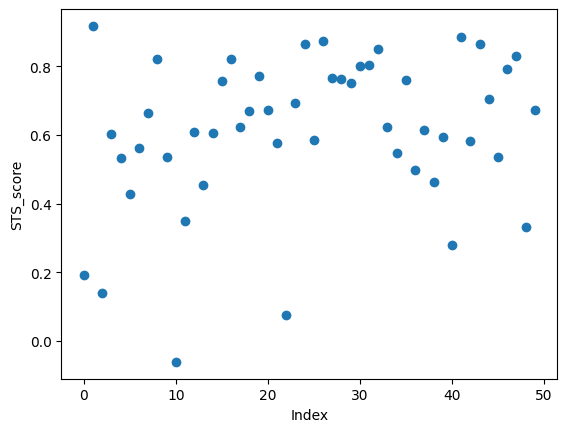

In [49]:
# Scatter plot
plt.scatter(df3.index,df3['sts_score'])
plt.xlabel('Index')
plt.ylabel('STS_score')
# plt.title('sts_score')
plt.show()

In [50]:
df3['sts_score'].describe()

count    50.000000
mean      0.612908
std       0.218911
min      -0.061679
25%       0.535702
50%       0.623863
75%       0.769402
max       0.917574
Name: sts_score, dtype: float64

In [67]:
temp=df3[(df3['sts_score']<0.4)]
temp.reset_index(drop=True,inplace=True)
print(len(temp))
temp['question'][1],temp['answer'][1]

11


('That song has the lyric "someone left the cake out in the rain"?',
 "MacArthur's Dark")

In [71]:
df3['question'][3],df3['answer'][3]

('I am the owner of an adult website called  Can anyone offer any SEO tips to help improve my SERP ranking on Google?',
 "Don't let apps that are liers put adds on your site. Like ones that say they have free age verification, but try charging your card. There all fucking liers, just dont understand why sites promote them and let them post there lies on your site. Also if you want your site to be better, when I click on mature anal lover's. It does not go to that it goes to a lying BS hook up site, that charges you for age verification. Like mature women just a bummer I can't get to the site. Big waist of my time really. Sure your making money from the bastards, if not making money from them. Your getting screwed then.")

In [72]:
df3['generated_ans'][3]

"Certainly! Here are some SEO tips that can help improve your SERP ranking on Google:  1. Optimize your website content: Make sure your website is optimized for search engines. Use relevant keywords, provide high-quality content, and structure your website with a clear navigation system.  2. Optimize your site for mobile: According to Google, mobile search accounts for over 80% of all searches on mobile devices. Ensure your website is optimized for mobile devices and provides a seamless user experience.  3. Build quality backlinks: Backlinks are a significant factor in Google's ranking algorithm. Build quality backlinks from reputable sources and directories.  4. Optimize your meta tags: Meta tags are essential for search engine optimization. Make sure your meta tags include relevant keywords and are optimized for your page's title, headline, and description.  5. Use structured data: Structured data is used by search engines to better understand the content of your website. Use structu

In [106]:
temp=pd.DataFrame(qa_dataset['train'])

In [119]:
temp[temp['question'].str.contains('obama',case=False)]

,question,answer
324,Why don't people do their homework and study i...,That would be because Obama is not a communist...
433,Why don't people do their homework and study i...,I don’t get why people on the right post such ...
899,What do you think of this tweet from Donald Tr...,"I am very happy that neither Obama, Bush 43, C..."
928,Why don't people do their homework and study i...,"Let's be real. You didn't “do your homework"" y..."
1195,Why don't people do their homework and study i...,Why should they if they already know you haven...
...,...,...
54762,What do you think of this tweet from Donald Tr...,"The King of Chaos, aka Liar in Chief, evidentl..."
55119,Why don't people do their homework and study i...,Ignorant Troll alert!\n
55429,What do you think of this tweet from Donald Tr...,I'm going to hold my judgement on this one.\n ...
56123,Why don't people do their homework and study i...,If you think Obama is a communist then you cle...


In [120]:
temp['question'][324]

"Why don't people do their homework and study it out to realize Obama is a communist?"

## NousResearch/Llama-2-7b-chat-hf

In [21]:
df4=copy.deepcopy(orig_df)

df4=df4[:50]
df4.reset_index(drop=True,inplace=True)

In [22]:


torch.random.manual_seed(0) 
model = AutoModelForCausalLM.from_pretrained( 
    "NousResearch/Llama-2-7b-chat-hf",  
    device_map="cuda",  
    torch_dtype="auto",  
    trust_remote_code=True,  
) 

tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-chat-hf") 



config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [23]:
del df

In [24]:
rouge1={}
rouge2={}
rougel={}
bert_f1={}
bert_p={}
bert_r={}
generated_ans={}
ques_asked={}
actual_ans={}
for i in range(len(df4)):
    if i%50==0:
        print(i)
    
    

    messages = [ 
        {"role": "system", "content": "You are a chatbot that answers questions"}, 
        {"role": "user", "content": df4['question'][i]} 
    ] 

    pipe = pipeline( 
        "text-generation", 
        model=model, 
        tokenizer=tokenizer, 
    ) 

    generation_args = { 
        "max_new_tokens": 300 
    } 

    output = pipe(messages, **generation_args) 
    answer=output[0]['generated_text']
    generated_ans[i]=answer[2]['content']
    ques_asked[i]=answer[1]['content']
    actual_ans[i]=df4['answer'][i]
    
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(df4['answer'][i], answer[2]['content'])
    rouge1[i]=scores['rouge1']
    rouge2[i]=scores['rouge2']
    rougel[i]=scores['rougeL']
    
    p,r,f1=score([answer[2]['content']],[df4['answer'][i]],lang='en',verbose=True )
    bert_f1[i]=f1.mean()
    bert_p[i]=p.mean()
    bert_r[i]=r.mean()




No chat template is set for this tokenizer, falling back to a default class-level template. This is very error-prone, because models are often trained with templates different from the class default! Default chat templates are a legacy feature and will be removed in Transformers v4.43, at which point any code depending on them will stop working. We recommend setting a valid chat template before then to ensure that this model continues working without issues.


0


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.26 seconds, 3.90 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.36 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.52 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 13.01 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.77 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.57 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.96 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.36 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.30 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.24 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.72 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.49 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.69 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.81 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 14.52 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.19 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.41 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.92 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.43 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.20 seconds, 5.03 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.36 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.23 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 11.08 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.51 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.03 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.78 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.92 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.24 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.77 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.12 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 8.95 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.21 seconds, 4.72 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 11.04 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.42 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.07 seconds, 13.52 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.31 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.17 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.50 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.78 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.06 seconds, 16.47 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 11.43 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.11 seconds, 9.18 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.14 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.19 seconds, 5.23 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.09 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.09 seconds, 10.62 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.14 seconds, 7.08 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 10.48 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.10 seconds, 9.58 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 12.92 sentences/sec


In [26]:
rouge1_precision=[]
rouge2_precision=[]
rougel_precision=[]

rouge1_recall=[]
rouge2_recall=[]
rougel_recall=[]

rouge1_fmeasure=[]
rouge2_fmeasure=[]
rougel_fmeasure=[]

bert_f1_list=[]
bert_p_list=[]
bert_r_list=[]

generates_ans_list=[]

for each in rouge1:
    rouge1_precision.append(rouge1[each][0])
    rouge1_recall.append(rouge1[each][1])
    rouge1_fmeasure.append(rouge1[each][2])

for each in rougel:
    rougel_precision.append(rougel[each][0])
    rougel_recall.append(rougel[each][1])
    rougel_fmeasure.append(rougel[each][2])
    
for each in rouge2:
    rouge2_precision.append(rouge2[each][0])
    rouge2_recall.append(rouge2[each][1])
    rouge2_fmeasure.append(rouge2[each][2])
        
    
for each in bert_f1:
    bert_p_list.append(bert_p[each].item())
for each in bert_r:
    bert_r_list.append(bert_r[each].item())
for each in bert_f1:
    bert_f1_list.append(bert_f1[each].item())

for each in generated_ans:
    generates_ans_list.append(generated_ans[each])

In [27]:
df4['rouge1_precesion']=rouge1_precision
df4['rouge2_precesion']=rouge2_precision
df4['rougel_precision']=rougel_precision

df4['rouge1_recall']=rouge1_recall
df4['rouge2_recall']=rouge2_recall
df4['rougel_recall']=rougel_recall

df4['rouge1_fmeasure']=rouge1_fmeasure
df4['rouge2_fmeasure']=rouge2_fmeasure
df4['rougel_fmeasure']=rougel_fmeasure



df4['bert_f1']=bert_f1_list
df4['bert_p']=bert_p_list
df4['bert_r']=bert_r_list


df4['generated_ans']=generates_ans_list

In [ ]:
df4['generated_ans'] = df4['generated_ans'].apply(html_tag_cleaner)

df4['generated_ans'] = df4['generated_ans'].apply(remove_urls)

df4['generated_ans'] = df4['generated_ans'].apply(replace_newlines)

df4['generated_ans'] = df4['generated_ans'].apply(remove_spaces)


In [30]:
df4['sts_score']=df4.apply(lambda row: sts_func(row['generated_ans'],row['answer']),axis=1)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

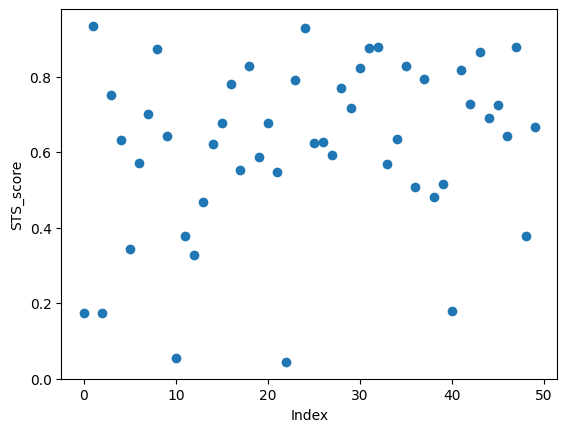

In [31]:
# Scatter plot
plt.scatter(df4.index,df4['sts_score'])
plt.xlabel('Index')
plt.ylabel('STS_score')
plt.show()

In [40]:
max(bert_f1_list),max(bert_p_list),max(bert_r_list)

(0.8637658953666687, 0.8749415278434753, 0.8891720771789551)

In [42]:
df4['sts_score'].describe()

count    50.000000
mean      0.617029
std       0.224488
min       0.044145
25%       0.524318
50%       0.643287
75%       0.788978
max       0.933960
Name: sts_score, dtype: float64

In [52]:
df4['question'][21],df4['answer'][14]

('Abe Lincoln was a self taught lawyer. Can anyone do something similar these days?',
 'I think if you can find something that you can do, enjoy, but most importantly SERVE other people, that can be your life’s purpose. It can feed you not only literally with a rewarding career, but also emotionally and spiritually in serving, protecting, and helping others.  I did it by helping out my fellow Asian brothers fight stereotypes and racism after I was hired by a Chinese Canadian mother who wanted me to help out her son who had been harassed by neo-Nazi’s.  For Captain Daniel Hyun here, he served in the military which later inspired to find his life purpose after he retired by also helping out his fellow brothers:')

In [54]:
df4['generated_ans'][17]

"  Sorry to hear that you're facing this challenging situation. As a chatbot, I can provide general information and suggestions, but please consult a financial advisor or a social worker for personalized advice.\n\nSince you're in Britain, you may be eligible for certain state benefits, such as:\n\n1. Pension Credit: If you're 62 or older and have a low income, you may be eligible for Pension Credit, which can help top up your income.\n2. Universal Credit: This is a means-tested benefit that can help with your living expenses, including rent or mortgage payments, food, and other bills.\n3. Housing Benefit: If you're renting, you may be eligible for Housing Benefit to help cover your rent payments.\n4. Council Tax Support: This is a reduction in your council tax bill if you're on a low income.\n\nTo apply for these benefits, you can contact the Jobcentre Plus in your area or visit their website. You can also use the government's benefits calculator to get an estimate of what you might b

In [55]:
df4['sts_score'][17]

0.5512667